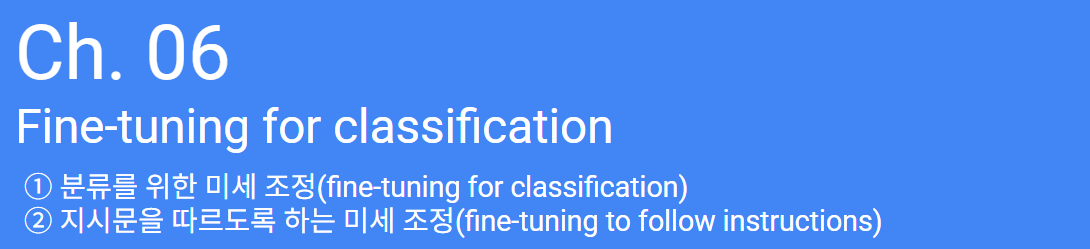

※ 실습 코드를 실행하기 위해서는 아래와 같은 파일이 필요합니다. 본 파일과 같은 폴더에 넣어주세요.

https://github.com/restful3/ds4th_study/tree/main/source/build-a-large-language-model-from-scratch/LLMs-from-scratch/ch06

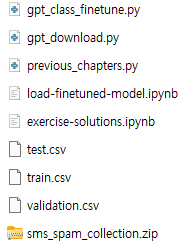

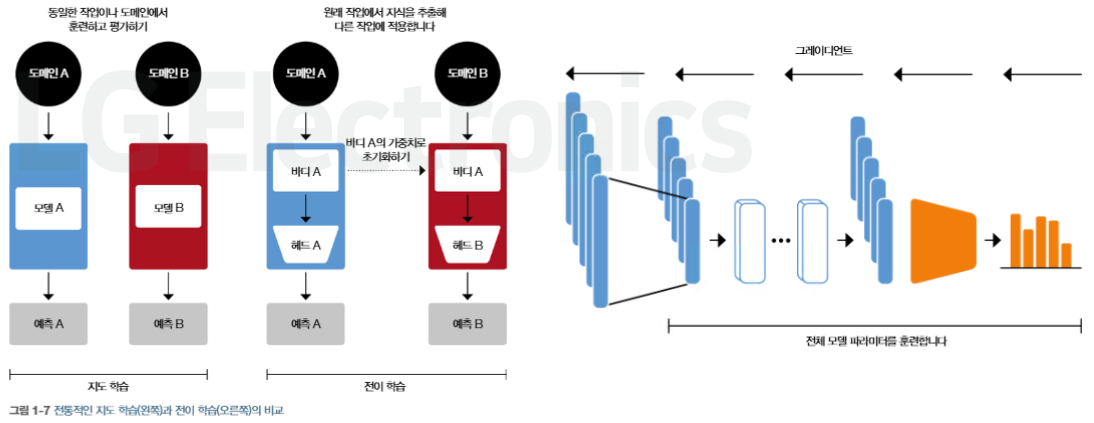

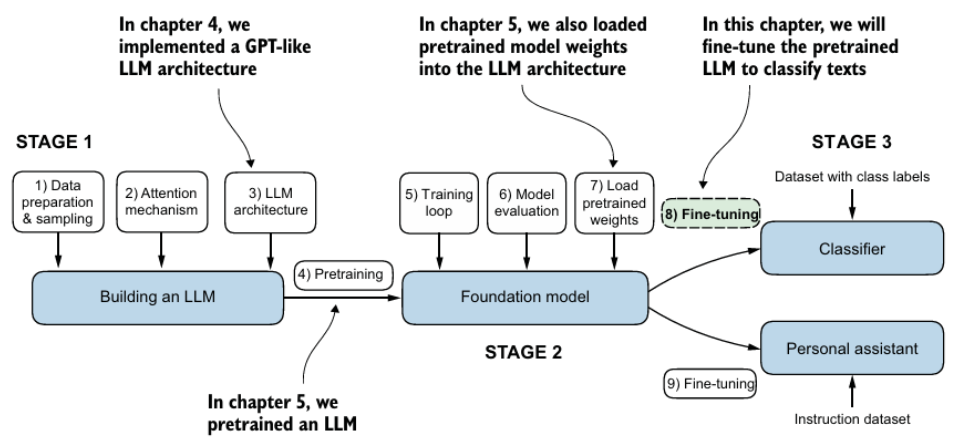

# 6.1 Different categories of fine-tuning

## Instruction Fine-Tuning (지시문 기반) VS Classification Fine-Tuning (분류 기반)

## 🧭 Instruction Fine-Tuning (지시문 기반)

자연어 지시문을 포함한 다양한 작업으로 모델을 훈련하여  
사용자의 지시를 이해하고 응답을 생성하는 능력을 향상시킴.

---

### 🎯 특징
- 복잡한 **지시문 기반의 다양한 작업** 수행 가능  
- 모델의 **유연성(Flexibility)** 및 **상호작용 품질(Interaction Quality)** 개선  
- **범용형(Generalist)** 모델로 다양한 도메인에 적용 가능  

---

### ⚖️ 장단점
**✅ 장점**
- 다양한 과제 수행 가능 (번역, 요약, 질의응답 등)

**⚠️ 단점**
- 더 많은 **데이터셋**과 **계산 자원(Compute)** 필요

---

### 💬 예시
> 사용자의 지시를 이해하고  
> “요약해줘”, “번역해줘”, “질문에 답해줘” 등의 요청을 정확히 수행하는 모델


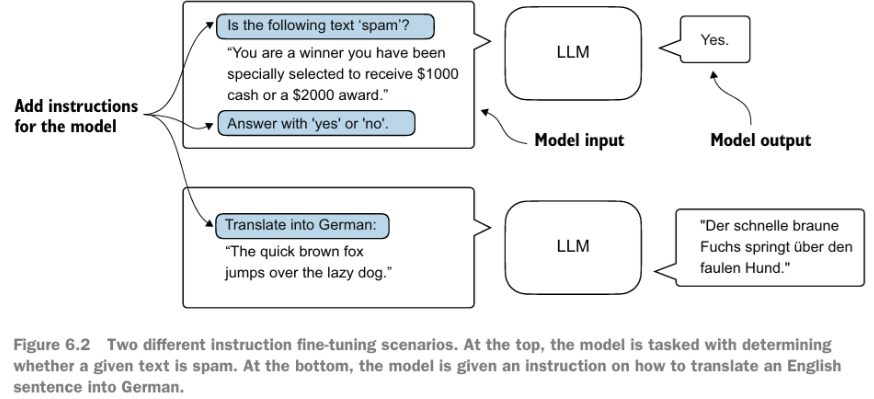

## 🧩 Classification Fine-Tuning (분류 기반)

### 📘 개념
사전 정의된 **클래스(Label)** 에 따라 데이터를 분류하도록 훈련  
예: `spam / not spam`, `감정 분석`, `뉴스 주제 분류` 등

---

### 🎯 특징
- 특정 클래스에 한정된 **분류 작업** 수행  
- **특화형(Specialist)** 모델로, 한정된 목적에 최적화됨  

---

### ⚖️ 장단점
**✅ 장점**
- 적은 데이터와 계산 자원으로도 **효율적 학습 가능**

**⚠️ 단점**
- 훈련된 클래스 이외의 응답 불가 → **범용성 낮음**


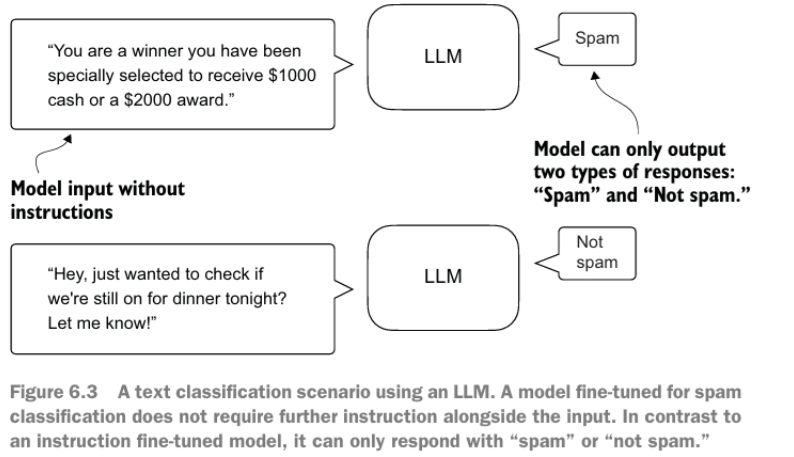

### 6.2 Preparing the dataset

### 🚀 확장 개요
이전에 **구현 및 사전 학습(Pretrained)** 한 GPT 모델을  
**분류 기반 미세 조정(Classification Fine-Tuning)** 으로 확장

---

### 💡 예시 데이터셋
- **문자 메시지(Text Message)** 데이터셋 사용  
- 클래스 구성:  
  - 📨 **Spam (스팸)**  
  - ✉️ **Non-Spam (비스팸)**  
- 직관적이고 실용적인 **분류 미세 조정 사례** 제공

---

### 🗒️ 참고 (NOTE)
- 문자 메시지는 일반적으로 **휴대전화 기반 메시지(SMS)** 를 의미  
- 동일한 절차는 **이메일 스팸 분류(Email Spam Classification)** 에도 적용 가능  
- 📎 **부록 B (Appendix B)** 에서 이메일 스팸 데이터셋 링크 제공

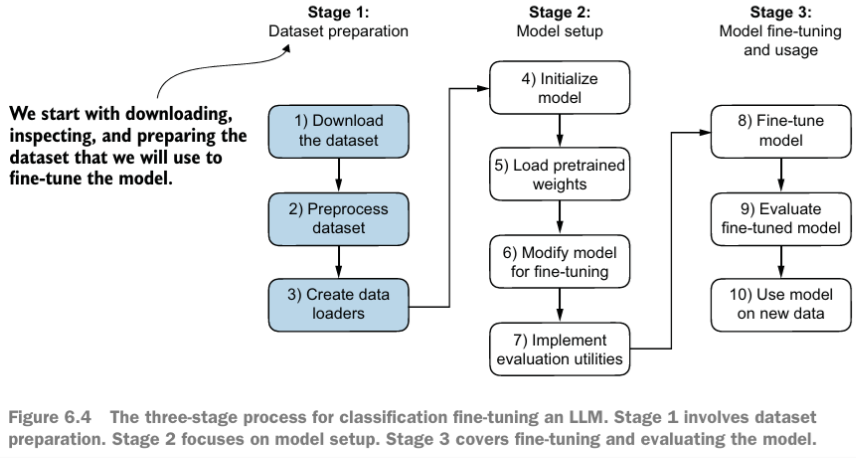

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # 파일 다운로드
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # 파일 압축 해제
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # .tsv 확장자 추가
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


균형있는 데이터셋 만들기

In [7]:
def create_balanced_dataset(df):
    
    # "spam" 샘플 개수 세기
    num_spam = df[df["Label"] == "spam"].shape[0]
    print(num_spam)
    num_ham = df[df["Label"] == "ham"].shape[0]
    print(num_ham)
    
    # "spam" 개수에 맞춰 "ham"을 무작위로 샘플링
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # 샘플링한 "ham"과 "spam"을 결합
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

747
4825
Label
ham     747
spam    747
Name: count, dtype: int64


In [8]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


Train (70%) → 모델 학습

Validation (10%) → 모델 튜닝 및 과적합 방지

Test (20%) → 최종 성능 평가

In [9]:
def random_split(df, train_frac, validation_frac):
    # 전체 DataFrame 셔플
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 분할 인덱스 계산
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # DataFrame 분할
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# 테스트 비율은 남은 0.2로 간주됩니다

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### 6.3 Creating data loaders

## 🧩 PyTorch 데이터 로더 구성 (Spam Classification Fine-Tuning)

---

### 📘 개요
이전의 텍스트 처리 방식과 유사하게 **PyTorch DataLoader** 구현  
과거에는 **슬라이딩 윈도우(Sliding Window)** 를 이용해 일정 길이 텍스트 청크를 생성하여 배치 학습 수행  
각 청크는 하나의 **학습 인스턴스(Training Instance)** 역할을 함

---

### 💡 새로운 데이터셋 특성
- **스팸(Spam) 데이터셋**은 길이가 다양한 **문자 메시지(Text Message)** 로 구성  
- 배치 처리를 위해 다음 두 가지 전략 중 하나를 선택해야 함  

#### ① Truncation
- 모든 메시지를 **가장 짧은 길이에 맞춰 자름**
- ✅ 계산 효율적  
- ⚠️ 정보 손실로 인해 **성능 저하 가능**

#### ② Padding
- 모든 메시지를 **가장 긴 길이에 맞춰 패딩 추가**
- ✅ 원문 정보 완전 보존  
- ⚠️ 계산량 증가

➡ **최종 선택:** ✅ **Padding 방식 (정보 손실 방지)**

---

### ⚙️ 구현 방식
- **패딩 토큰(Padding Token)**: `<|endoftext|>`  
- **토큰 ID**: `50256`  
- 문자열을 직접 추가하지 않고, **인코딩된 토큰 ID**를 삽입  
- **GPT-2 `tiktoken` 토크나이저**로 ID 검증 가능  

---

### 🧾 정리
다양한 길이의 메시지를 효율적으로 학습하기 위해  
모든 메시지를 **가장 긴 메시지 길이에 맞춰 패딩 처리**함으로써  
데이터 **일관성**과 **모델 성능**을 동시에 확보함.


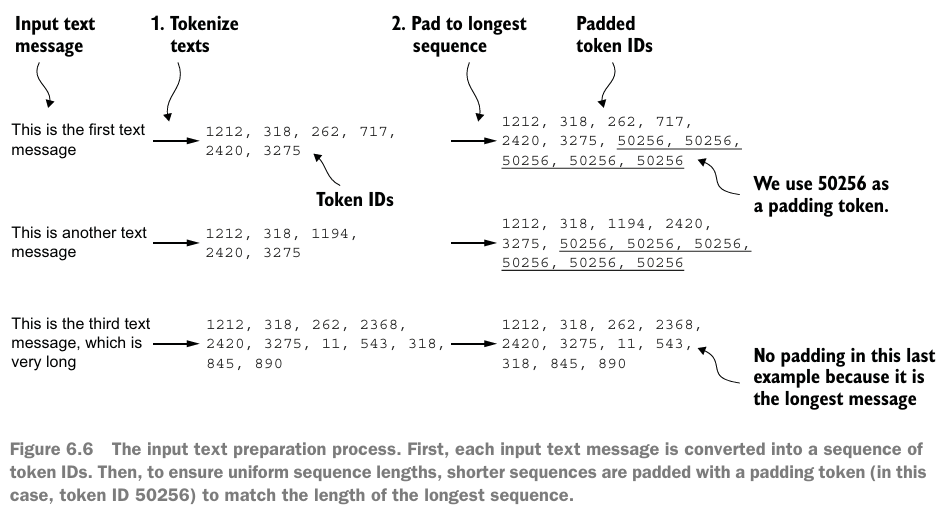

tiktoken = OpenAI 모델용 초고속 토크나이저(Tokenization library)

GPT-2, GPT-3, GPT-4 같은 OpenAI 모델이 실제로 사용하는 토크나이징 방식을 그대로 구현해놓은 패키지

In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [13]:
import torch
print(torch.__version__)           # 2.6.0 이어야 함
print(torch.cuda.is_available())   # GPU 사용 가능하면 True
if torch.cuda.is_available():
    print(torch.version.cuda) 

2.6.0+cpu
False


In [ ]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # 텍스트를 미리 토큰화
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # 시퀀스가 max_length보다 길면 잘라냄
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 가장 긴 시퀀스 길이에 맞춰 패딩
        # 이미 토크나이저로 인코딩된 텍스트들의 리스트
        # [15496, 11, 318, 257] + [50256, 50256, 50256, 50256, 50256, 50256]
        # → [15496, 11, 318, 257, 50256, 50256, 50256, 50256, 50256, 50256]
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    # 데이터셋에서 특정 인덱스의 샘플(한 건)을 반환하는 함수
    def __getitem__(self, index):
        # index번째 문장(토큰 리스트) 를 가져옴
        encoded = self.encoded_texts[index]
        # index번째 행의 "Label" 컬럼 값을 가져옴
        label = self.data.iloc[index]["Label"]
        # 텍스트와 라벨을 PyTorch Tensor로 변환해서 반환
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    # 데이터셋의 총 샘플 개수
    def __len__(self):
        return len(self.data)
    # 가장 긴 인코딩 시퀀스의 길이
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # 참고: 이 메서드를 더 파이썬답게 구현하면
        # 아래와 같으며, 다음 장에서도 사용합니다:
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [15]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [16]:
print(train_dataset.__dict__)

{'data':       Label                                               Text
0         0                Dude how do you like the buff wind.
1         0  Tessy..pls do me a favor. Pls convey my birthd...
2         1  Reminder: You have not downloaded the content ...
3         1  Got what it takes 2 take part in the WRC Rally...
4         1  Shop till u Drop, IS IT YOU, either 10K, 5K, £...
...     ...                                                ...
1040      1  4mths half price Orange line rental & latest c...
1041      1  Thanks for the Vote. Now sing along with the s...
1042      1  IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...
1043      1  Urgent! call 09066612661 from landline. Your c...
1044      0  His frens go then he in lor. Not alone wif my ...

[1045 rows x 2 columns], 'encoded_texts': [[35, 2507, 703, 466, 345, 588, 262, 6940, 2344, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

In [17]:
print(train_dataset.__dict__.keys())

dict_keys(['data', 'encoded_texts', 'max_length'])


GPT2-small 모델은 컨텍스트 길이(context length) 제한 덕분에 최대 1,024개의 토큰까지 처리

🧩 검증·테스트 세트 처리 요약

🔹 1. 패딩 (Padding)

검증 세트와 테스트 세트는
훈련 세트에서 가장 긴 시퀀스의 길이에 맞춰 패딩한다.

이렇게 해야 모든 입력 시퀀스의 길이가 동일해져 모델 입력이 가능함.

🔹 2. 잘라내기 (Truncation)

검증/테스트 샘플 중 훈련 세트보다 더 긴 시퀀스가 있다면,
encoded_text[:self.max_length] 코드에 의해 자동으로 잘라낸다.

🔹 3. 선택적 설정

잘라내기(truncation)는 선택 사항(optional).

단, 검증/테스트 데이터의 시퀀스가 1,024 토큰 이하라면
max_length=None 으로 설정해도 문제없다.

In [18]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

🧩 연습 6.1 — 컨텍스트 길이 늘리기 요약

- **목적:** 모델이 지원하는 최대 토큰 수(예: 1,024)까지 입력을 패딩하고 성능 변화를 관찰.  
- **좋을 때:** 긴 문맥이 필요한 데이터(문서 요약, QA 등) → 정보량 증가로 성능 향상 가능.  
- **나쁠 때:** 짧은 문장 데이터(SMS 스팸 등) → 불필요한 계산 증가, 과적합, 성능 저하 가능.  
- **핵심 요약:**  
  > 긴 문맥이 필요한 경우에만 효과적이며, 짧은 입력에서는 성능 향상 거의 없음.


🧩 데이터 로더 구성 요약

- **설명:** 텍스트 데이터를 다룰 때와 유사하게 데이터셋을 입력으로 하여 `DataLoader`를 생성한다.  
- **차이점:** 이번에는 **타깃(target)** 이 텍스트의 다음 토큰이 아니라 **클래스 레이블(class label)** 임.  
- **예시:**  
  - 배치 크기(`batch_size`) = 8  
  - 각 배치 → 길이 120의 **훈련 샘플 8개** + 각 샘플의 **클래스 레이블**  
- 📘 그림 6.7에 시각적으로 표현됨.


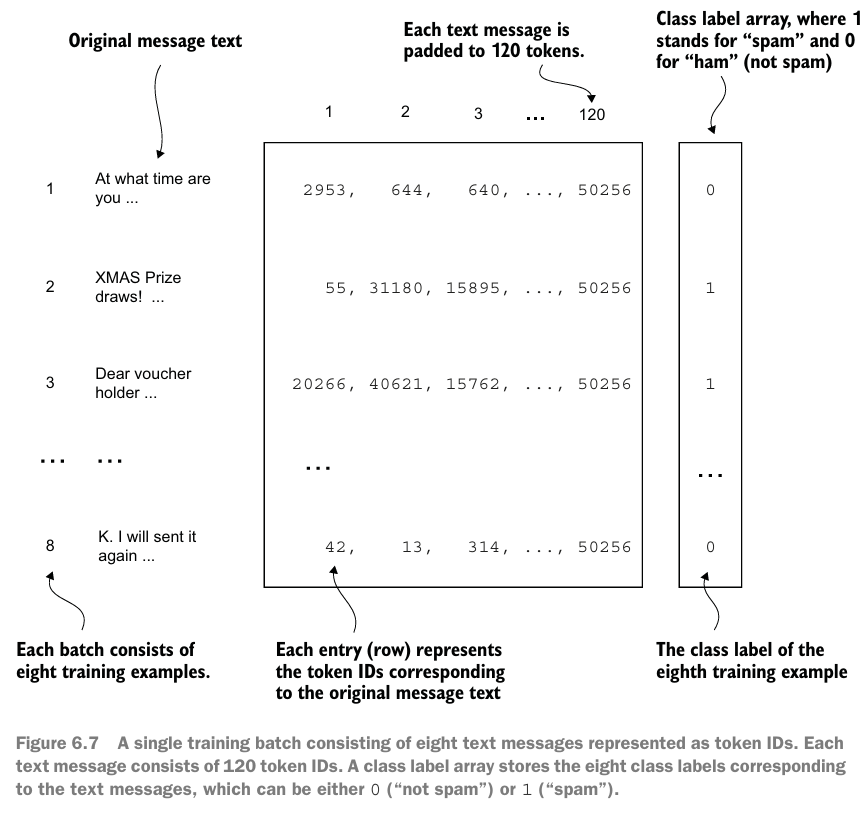

🧩 데이터 로더 생성 요약

- **설명:** 아래 코드에서는 **훈련(Training)**, **검증(Validation)**, **테스트(Test)** 세 가지 데이터 로더를 생성한다.  
- **기능:** 각 데이터 로더는 **문자 메시지(Text Messages)** 와 **레이블(Labels)** 을  
  **배치 크기(batch size) = 8** 로 묶어 불러온다.

In [19]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [20]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


입력 배치는 120개의 토큰으로 구성된 8개의 훈련 예제

레이블 텐서(label tensor) 는 이 8개의 훈련 예제에 해당하는 클래스 레이블(class labels)

In [22]:
import math

num_batches = math.ceil(len(train_dataset) / batch_size)
print(num_batches)


131


In [25]:
len(train_dataset) / batch_size

130.625

In [23]:
len(train_dataset)

1045

In [24]:
 print(f"{len(train_loader)} training batches")
 print(f"{len(val_loader)} validation batches")
 print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


미완성 배치도 훈련 데이터에 포함해야하지 않을까...

---

###  6.4 Initializing a model with pretrained weights

모델 준비 → 사전 학습된(pretrained) 모델을 초기화(initializing) 하는 것부터 시작

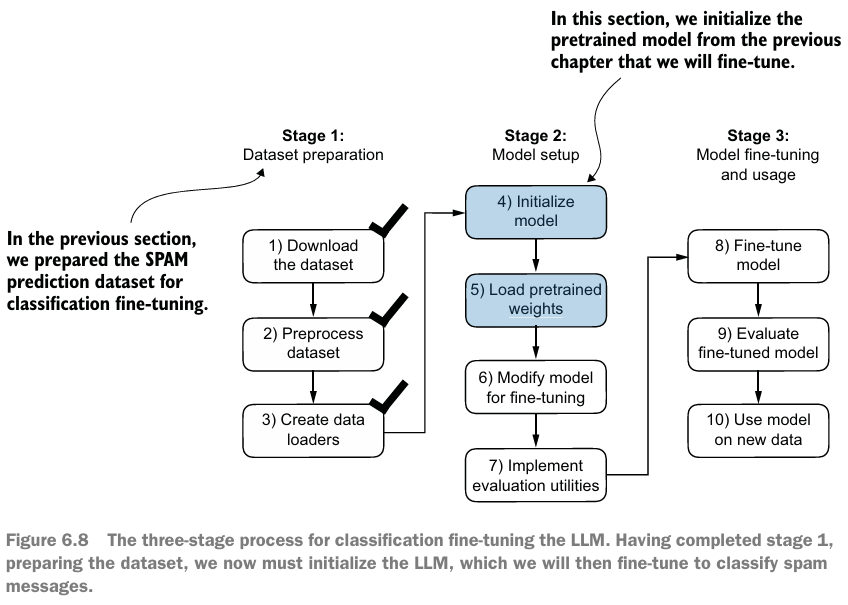

In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘 수
    "context_length": 1024,  # 컨텍스트 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향, True는 모델 표현력과 학습 안정성을 약간 향상시키는 효과
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

🧩 GPT 모델 가중치 로드 요약

- **단계:**  
  1. `gpt_download.py` 파일에서 `download_and_load_gpt2` 함수를 가져온다.  
  2. 5장에서 사용했던 `GPTModel` 클래스와 `load_weights_into_gpt` 함수를 **재사용(reuse)** 한다.  
  3. **다운로드한 가중치(weights)** 를 GPT 모델에 로드하여 초기화한다.


In [ ]:
# GPT-2 모델을 Hugging Face나 OpenAI의 공개 저장소에서 다운로드하고, 모델 가중치(weights) 를 메모리로 불러오는 함수
from gpt_download import download_and_load_gpt2
# GPT-2의 구조(트랜스포머 블록, 임베딩, 어텐션 등)를 구현한 PyTorch 모델 클래스
# 다운로드한 가중치(params)를 GPTModel 인스턴스에 주입(로드)하는 함수
from previous_chapters import GPTModel, load_weights_into_gpt
# 로컬에 `previous_chapters.py` 파일이 없다면
# `llms-from-scratch` PyPI 패키지에서 가져올 수 있습니다.
# 자세한 내용: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 예)
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt

# "124M" 부분만 추출하는 코드
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
# 모델의 설정(settings) 과 가중치(parameters) 를 메모리로 불러와 반환
# settings  # → 모델 설정값들 (예: vocab_size, context_length 등)
# params    # → 실제 학습된 가중치 텐서들의 딕셔너리
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

# BASE_CONFIG는 GPT의 기본 구조 설정
model = GPTModel(BASE_CONFIG)
# 빈 GPT 구조 + 학습된 파라미터
load_weights_into_gpt(model, params)
# 학습용 기능(예: dropout, layer normalization update)을 끄고
# 모델이 추론(inference) 상태로 동작하도록 평가(evaluation) 모드로 전환하는 명령
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [ ]:
from previous_chapters import (
    generate_text_simple,  # 모델이 주어진 입력 토큰에서 다음 단어를 예측하며 새로운 토큰을 생성
    text_to_token_ids,     # 문자열("Every effort moves you")을 토큰 ID 리스트로 변환
    token_ids_to_text      # 생성된 토큰 ID 리스트를 다시 사람이 읽을 수 있는 문장으로 변환
)

# 다른 방법:
# from llms_from_scratch.ch05 import (
#    generate_text_simple,
#    text_to_token_ids,
#    token_ids_to_text
# )

# 모델이 이어서 문장을 생성할 시작 문장
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),    # 입력 텍스트를 토큰 ID로 변환
    max_new_tokens=15,                           # 새로 생성할 토큰의 최대 개수 (즉, 모델이 15개의 단어/토큰을 예측함)
    context_size=BASE_CONFIG["context_length"]   # 모델이 한 번에 볼 수 있는 컨텍스트(문맥) 길이 (보통 1024)
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [36]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

text = "Every effort moves you"
tokens = tokenizer.encode(text)
print(tokens)

[6109, 3626, 6100, 345]


In [41]:
text = "Every effort moves you forward.\n\nThe first step is to understand the importance of your work"
tokens = tokenizer.encode(text)
print(tokens)

[6109, 3626, 6100, 345, 2651, 13, 198, 198, 464, 717, 2239, 318, 284, 1833, 262, 6817, 286, 534, 670]


##### 분류기로 미세 조정하기 전에, 프롬프트만으로 스팸 메시지를 이미 분류할 수 있는지 확인

In [34]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


---

### 6.5 Adding a classification head

🧩 분류용 미세 조정을 위한 모델 수정 요약

- **목적:** 사전 학습된 LLM을 **스팸 분류(classification fine-tuning)** 에 맞게 수정.  
- **방법:**  
  - 기존 출력층(Output Layer): 은닉 표현 → **50,257개 어휘(vocabulary)**  
  - 변경 후 출력층: 은닉 표현 → **2개 클래스 (0: not spam, 1: spam)**  
- **결론:** 모델 구조는 그대로 유지하되, **출력층만 교체**하여 분류 작업에 적합하게 만든다.

출력층 노드 구성 요약

- **이진 분류**에서는 이론상 **출력 노드 1개**만으로도 가능하지만,  
  손실 함수 수정이 필요함 (참고: *Losses Learned—Optimizing NLL and Cross-Entropy in PyTorch*).  
- **일반적인 방법:** 클래스 개수 = 출력 노드 개수.  
  - 예: 3클래스 문제 → 3개의 출력 노드 사용.  
- ✅ 결론: **클래스 수에 맞춰 출력층 노드를 설정**하는 것이 가장 일반적이고 확장성이 높음.

입력 토큰 하나 → 768차원 벡터로 변환 → 50257개 후보 단어 중 하나를 확률적으로 선택


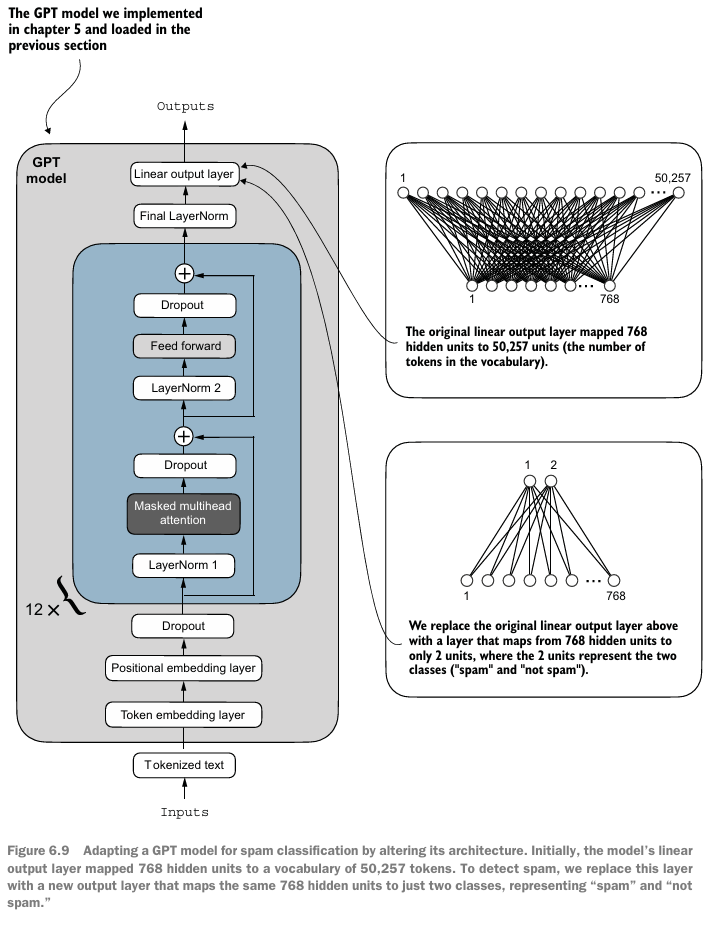

In [42]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

##### out_head 를 새로운 출력층으로 교체하고(그림 6.9 참고), 이 새로운 층을 미세 조정(fine-tuning)

🧩 선택적 레이어 미세 조정 요약

- **핵심 아이디어:**  
  사전 학습된 모델은 이미 언어의 기본 구조를 학습했기 때문에  
  모든 레이어를 미세 조정할 필요는 없음.

- **하위 레이어(lower layers):**  
  문법, 구문, 의미 등 **언어의 기본 구조**를 담당 → 대부분의 작업에 공통적으로 유용.

- **상위 레이어(upper layers):**  
  **세밀한 언어 패턴**과 **작업 특화 특징(task-specific features)** 을 학습 →  
  이 부분만 미세 조정해도 새로운 작업에 충분히 적응 가능.

- **장점:**  
  일부 레이어만 조정하므로 **계산 효율성↑**, **훈련 속도↑**.

- **추가 참고:**  
  어떤 레이어를 미세 조정하는 것이 효과적인지는 **부록 B(Appendix B)** 참고.

 모든 층을 학습 불가능하게 만들어 모델을 동결

In [43]:
for param in model.parameters():
    param.requires_grad = False

50,257차원(어휘 크기)으로 사상하던 출력층(model.out_head)을 교체

 "spam"과 "not spam" 두 클래스를 예측하는 이진 분류를 위해 모델을 미세 조정하므로, 아래와 같이 출력층을 교체하면 기본적으로 학습 가능한 상태

즉, 새로운 model.out_head 출력층(output layer)은 기본적으로 requires_grad 속성이 True 로 설정 → 학습 중에 이 층만 업데이트

In [44]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

실험 결과에 따르면, 추가적인 몇 개의 레이어를 함께 미세 조정(fine-tune) 하면 모델의 예측 성능(predictive performance) 이 눈에 띄게 향상

따라서, 마지막 트랜스포머 블록(transformer block)과 이 블록을 출력층과 연결하는 최종 LayerNorm 모듈 도 학습 가능(trainable)하도록 설정

즉, 최종 LayerNorm과 마지막 트랜스포머 블록의 requires_grad 속성을 True 로 설정

In [45]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

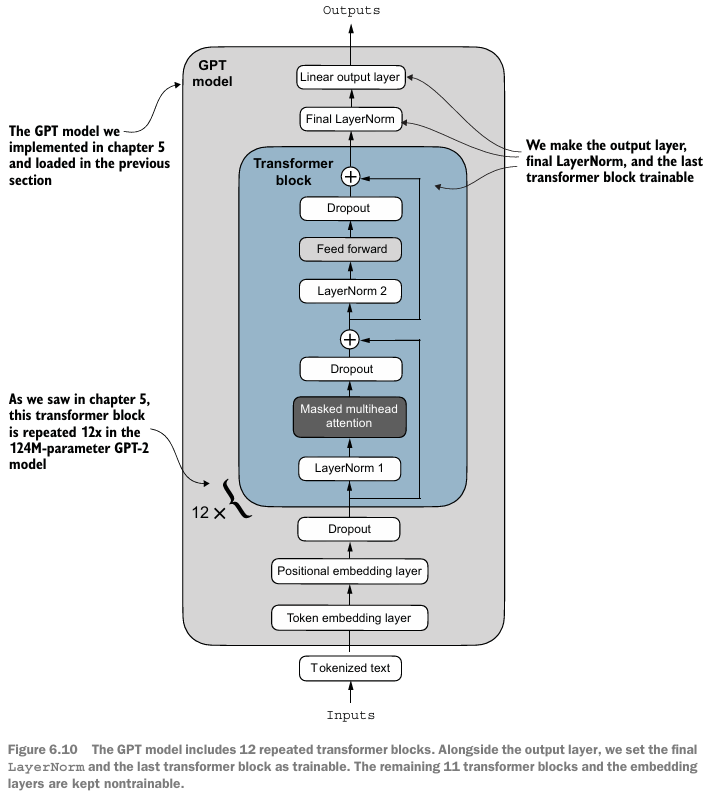

새로운 출력층(output layer)을 추가하고,

일부 레이어를 학습 가능(trainable) 또는 비학습(non-trainable) 상태로 표시했지만,

이 모델은 여전히 이전과 동일한 방식으로 사용가능

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [47]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


🧩 출력 텐서 변화 및 미세 조정 대상 요약

- **이전 구조:**  
  - 출력 텐서 형태: `[1, 4, 50257]`  
  - `50257` → 어휘 크기(vocabulary size)  
  - 행(row) 수 4 → 입력 토큰 수  

- **현재 구조 (출력층 교체 후):**  
  - 출력 텐서 형태: `[1, 4, 2]`  
  - 열(column) 수 2 → 클래스 수 (“not spam”, “spam”)  

- **미세 조정(fine-tuning) 대상:**  
  - 전체 출력 행(모든 토큰)을 학습할 필요 없음  
  - **마지막 출력 토큰의 행(last row)** 에 집중  
  - 해당 행이 “스팸 여부”를 결정하는 대표 벡터 역할 수행  

인과적 어텐션 덕분에 네 번째(마지막) 토큰은 다른 모든 토큰에 대한 정보를 포함하는 유일한 토큰이므로 가장 많은 정보를 담고 있음

🧩 마지막 출력 토큰에 집중하는 이유

- **목적:**  
  출력값을 클래스 레이블(class label) 예측으로 변환하기 전에,  
  왜 마지막 출력 토큰(last output token)에만 집중하는지 이해해야 함.

- **어텐션 메커니즘:**  
  각 입력 토큰은 **다른 모든 토큰과의 관계**를 학습함.

- **인과적 어텐션 마스크 (Causal Attention Mask):**  
  - GPT 계열 모델에서 사용됨 (3장 참고)  
  - 각 토큰이 **자신과 이전 토큰들만** 참조 가능  
  - 미래 토큰을 보지 못하도록 제한 → 언어의 순방향 예측 성질 유지  

- **결과:**  
  마지막 토큰은 **문장 전체의 문맥 정보**를 가장 풍부하게 포함하므로,  
  **분류(classification)** 시 이 마지막 출력 벡터만 사용함.  

In [49]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


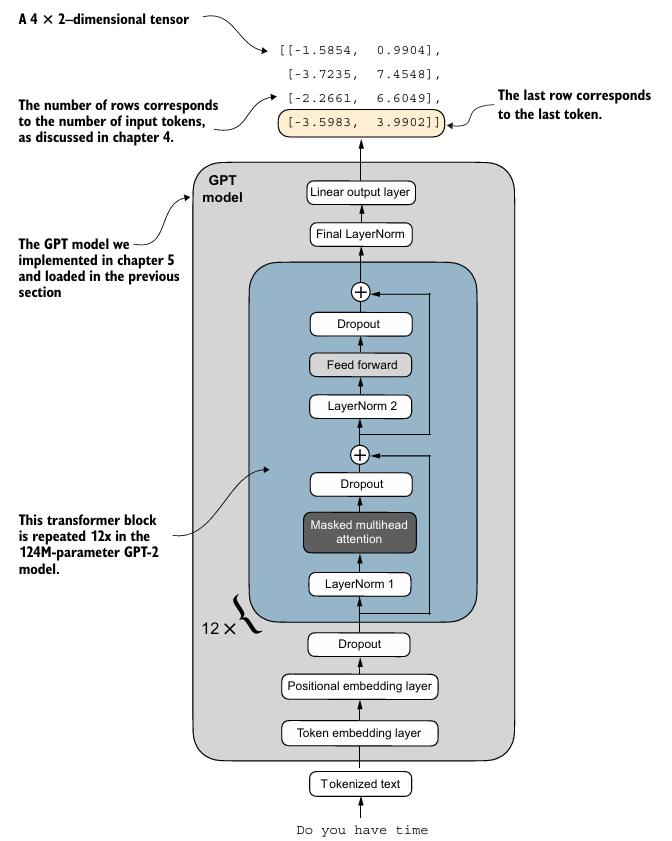

어텐션 스코어(attention score) 행렬을 나타낸 그림, 셀(cell) 안의 값은 “어텐션 강도(attention score)”

각 행은 “현재 토큰”이 어느 단어에 주의를 기울이는지를 나타냄

각 열(Column)은 “참조 대상”이 되는 이전 토큰들을 나타냄

GPT 같은 디코더 기반 트랜스포머 모델은 미래 단어를 미리 보면 안 되기 때문에, 오른쪽 위의 회색 칸들이 “mask(가려짐)” 되어 있음 → Causal Attention 

마지막 토큰이 문장 전체의 의미를 가장 잘 요약하는 벡터

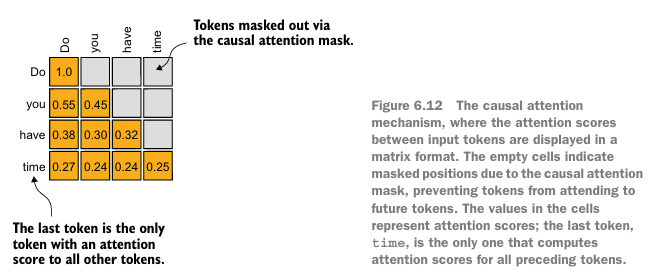

Exercise 6.3 Fine-tuning the first vs. last token 

Try fine-tuning the first output token. Notice the changes in predictive performance  compared to fine-tuning the last output token.

당연히?

---

### 6.6 Calculating the classification loss and accuracy

🧩 모델 출력 → 클래스 예측 변환 요약

- **미세 조정 전 준비:**  
  - 그림 6.13처럼, 미세 조정 과정에 사용할 **모델 평가 함수(evaluation functions)** 를 구현해야 함.

- **출력값을 클래스 레이블로 변환하는 방식:**  
  1. **Softmax 함수**로 출력값을 확률로 변환  
  2. **Argmax 함수**로 가장 높은 확률의 인덱스를 선택  
  3. 선택된 인덱스 → “spam” 또는 “not spam” 클래스 결정

- **이전 방식과의 차이:**  
  - 기존 LLM: **50,257차원** 출력 (어휘 단어별 확률)  
  - 스팸 분류 모델: **2차원** 출력 (“spam”, “not spam”)  

📘 *즉, softmax + argmax 구조는 동일하지만, 출력 차원만 50,257 → 2로 축소됨.*

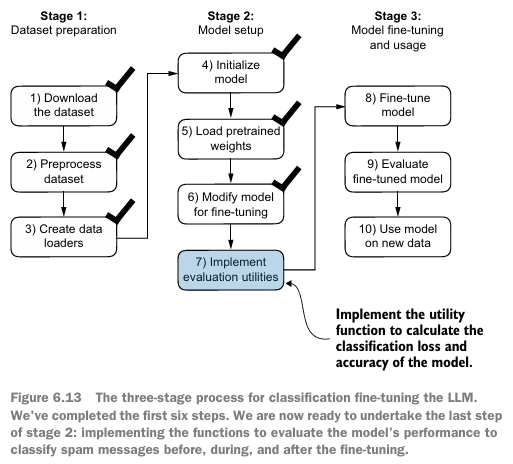

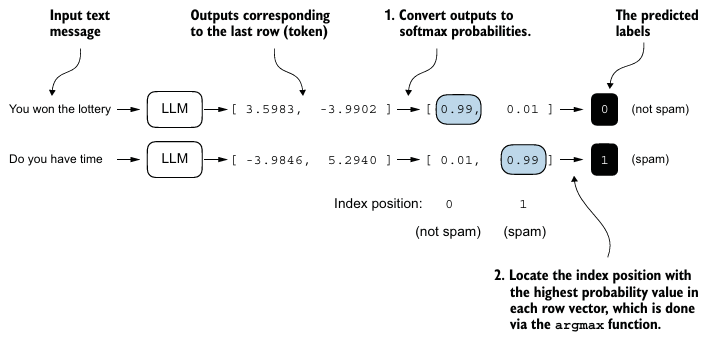

In [50]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


출력(로짓)을 softmax 함수로 확률 점수로 변환하고, argmax 함수로 가장 큰 확률 값을 갖는 인덱스 계산

In [51]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


→ 코드의 출력은 1이며, 이는 모델이 입력된 문장을 “스팸(spam)” 으로 예측

softmax 함수의 사용은 선택 사항(optional) → 출력 값이 가장 클수록 확률도 가장 크기 때문

In [52]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


분류 정확도(classification accuracy) 계산에도 활용

즉, 데이터셋 전체에서 정확히 예측한 비율(%) 을 측정하는 데 사용

분류 정확도(classification accuracy) 를 계산하기 위해 데이터셋의 모든 예시에 대해 argmax 기반 예측 코드(argmax-based prediction code) 를 적용하고, 정확하게 예측된 비율을 계산

calc_accuracy_loader 함수를 정의

In [54]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # 마지막 출력 토큰의 로짓
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

이 함수를 적용해 여러 데이터셋(dataset) 에 대한 분류 정확도(classification accuracy) 를 계산

효율성을 위해 10개의 배치(batch) 만을 사용해 정확도를 추정

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 참고:
# 아래 줄의 주석을 해제하면(가능한 경우) Apple Silicon 칩에서 코드를 실행할 수 있습니다.
# M3 MacBook Air 기준으로 Apple CPU보다 약 2배 빠릅니다.
# 작성 시점의 PyTorch 2.4에서는 CPU와 MPS 결과가 동일했습니다.
# 다만 이전 버전의 PyTorch에서는 MPS 사용 시 다른 결과가 나올 수 있습니다.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # nn.Module 클래스는 model = model.to(device) 할당이 필요 없음

torch.manual_seed(123) # 학습 데이터 로더 셔플에 따른 재현성을 위해 시드 고정

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


→ 무작위 예측(random prediction) 수준

🧩 손실 함수 정의 및 미세 조정 준비 요약

- **목표:**  
  모델의 **스팸 분류 정확도(spam classification accuracy)** 를 최대화하는 것.  
  → 올바른 클래스 레이블 출력:  
    - `0` → 비스팸(non-spam)  
    - `1` → 스팸(spam)

- **이유:**  
  - **분류 정확도(classification accuracy)** 는  
    **미분 불가능한 함수(non-differentiable function)** 이므로,  
    경사하강법(gradient descent)으로 학습할 수 없음.  
  - 따라서, 정확도 향상을 위한 **대체 지표(proxy)** 로  
    **크로스 엔트로피 손실(cross-entropy loss)** 을 사용함.

- **코드 조정:**  
  - 기존 `calc_loss_batch()` 함수 구조는 동일.  
  - 단, 모든 토큰(`model(input_batch)`)이 아닌  
    **마지막 토큰(`model(input_batch)[:, -1, :]`)** 만을  
    **최적화 대상**으로 설정.

📘 *요약:*  
> 미세 조정(fine-tuning)을 위해,  
> “정확도 대신 크로스 엔트로피 손실”을 사용하고,  
> “마지막 토큰만 최적화”하는 방식으로 학습을 수행한다.

크로스 엔트로피 손실(cross-entropy loss)은
확률적으로 “정답에 얼마나 가까운가”를 연속적인 값으로 계산

따라서, 연속적이고 미분 가능(differentiable) 하기 때문에
경사하강법으로 모델의 가중치를 업데이트 가능

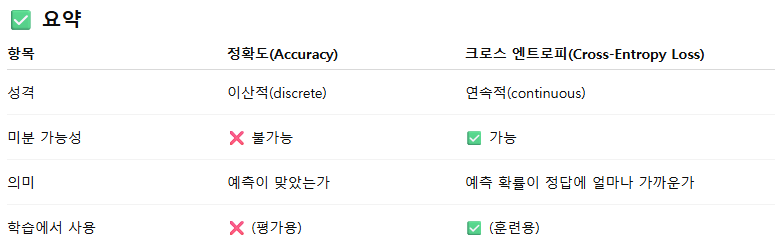

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # 모델이 각 클래스에 대해 계산한 “확률 전 단계의 값”
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

※ Softmax를 적용하기 전: logits은 단순히 “점수” 형태. 값의 크기만 중요하지, 절댓값 자체는 의미가 없음.

   Softmax를 적용하면, “비스팸 0.1%, 스팸 99.9% 확률”이라는 의미로 변환

※ CrossEntropy = LogSoftmax + NegativeLogLikelihood

앞서 정의한 데이터 로더(data loaders)에서 가져온 단일 배치(single batch) 에 대해

손실(loss)을 계산하기 위해 calc_loss_batch 함수를 사용

데이터 로더 내의 모든 배치(all batches) 에 대한 손실을 계산하기 위해,

이전과 마찬가지로 calc_loss_loader 함수를 정의

In [57]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

훈련 정확도를 계산했던 것과 유사하게,
각 데이터셋(dataset) 에 대한 초기 손실(initial loss) 을 계산

모델을 학습시키기 전, 즉 미세 조정(fine-tuning) 이전 상태에서
모델이 현재 데이터를 얼마나 잘 예측하는지를 측정한 값

“출발점 성능(baseline performance)” 을 의미

In [58]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


※ 훈련(training)할 때는 gradient가 필요하지만,
모델 평가(evaluation) 나 손실(loss)/정확도 계산만 할 때는
역전파를 하지 않아도 됨

    PyTorch의 autograd 기능을 일시적으로 비활성화, 모델 평가 시

🧩 모델 미세 조정(fine-tuning) 개요

- **목표:**  
  모델을 미세 조정하여 **훈련 세트 손실(training set loss)** 을 최소화하는 것.

- **핵심 아이디어:**  
  손실을 최소화하면 모델이 더 정확하게 학습되어  
  **분류 정확도(classification accuracy)** 가 향상됨.

- **결론:**  
  다음 단계에서는 **훈련 함수(training function)** 를 구현해  
  손실을 줄이고, 모델의 예측 성능을 개선한다.

---

### 6.7 Fine-tuning the model on supervised data

🧩 미세 조정용 훈련 함수 요약

- **목적:**  
  사전 학습된 LLM을 **미세 조정(fine-tune)** 하여  
  **스팸 분류 정확도(spam classification accuracy)** 향상.

- **훈련 루프 구조:**  
  - 그림 6.15의 훈련 루프는 **사전 학습(pretraining)** 때와 동일한 형태.  
  - 단, **모델 평가 방식**만 다름:
    - 이전: 샘플 텍스트(sample text) 생성  
    - 현재: 분류 정확도(classification accuracy) 계산

- **결론:**  
  동일한 훈련 루프 구조를 유지하되,  
  **평가 기준을 “정확도”로 변경**하여 모델을 미세 조정한다.

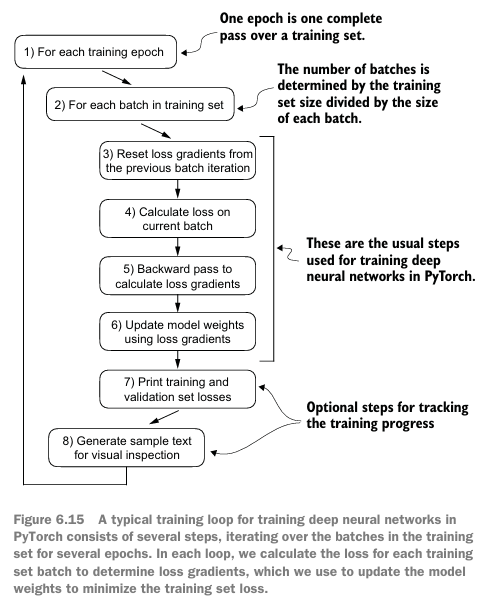

🧩 훈련 함수 구조 요약

- **기본 구조:**  
  그림 6.15의 개념을 구현한 훈련 함수는  
  `train_model_simple` (사전 학습용 함수)와 거의 동일한 형태.

- **주요 차이점:**  
  1. **토큰 수(tokens)** 대신 → **훈련 예시 수(examples_seen)** 추적  
  2. 각 **에폭(epoch)** 종료 시  
     - 이전: 샘플 텍스트(sample text) 출력  
     - 현재: **분류 정확도(accuracy)** 계산

- **결론:**  
  pretraining 구조를 유지하되,  
  **학습 단위와 평가 방식만 변경**하여 fine-tuning에 적합하게 조정.

In [59]:
# 전체적으로 5장의 `train_model_simple`과 동일
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # 손실과 처리한 예제 수를 저장할 리스트 초기화
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # 메인 학습 루프
    for epoch in range(num_epochs):
        model.train()  # 학습 모드로 전환

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 이전 배치에서 누적된 그래디언트 초기화
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 손실 그래디언트 계산
            optimizer.step() # 그래디언트로 가중치 업데이트
            examples_seen += input_batch.shape[0] # 변경: 토큰 대신 예제 수 추적
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 각 에폭 이후 정확도 계산
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

train_classifier_simple에서 사용하는 evaluate_model 함수는 5장에서 사용한 것과 동일

In [60]:
# 5장과 동일
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

옵티마이저(optimizer) 를 초기화하고,
훈련 에폭(epoch) 수를 설정한 뒤,
train_classifier_simple 함수를 사용해 훈련(training) 을 시작

M3 MacBook Air 노트북에서는 약 6분

V100 또는 A100 GPU 에서는 30초 미만이 소요

In [61]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 18.72 m

matplotlib를 사용해 학습 및 검증 세트의 손실 함수를 시각화

In [63]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 에폭별 학습/검증 손실 그래프 그리기
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 처리한 예제 수를 위한 두 번째 x축 생성
    ax2 = ax1.twiny()  # 동일한 y축을 공유하는 두 번째 x축 생성
    ax2.plot(examples_seen, train_values, alpha=0)  # 눈금 정렬용 보이지 않는 플롯
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # 여유 공간을 확보하도록 레이아웃 조정
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

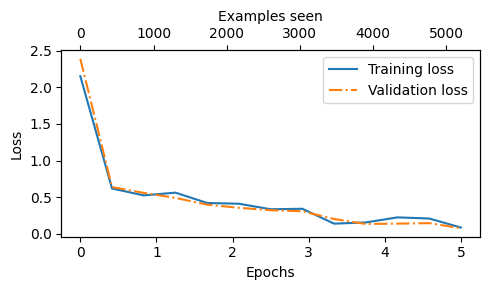

In [64]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

→ 분석

손실이 감소하는 추세를 통해 모델이 잘 학습

학습 손실과 검증 손실이 매우 비슷하므로 모델이 학습 데이터에 과적합되는 경향이 크지 않다는 점도 확인

새로운 데이터에도 잘 작동하고 있다는 의미

정확도 시각화

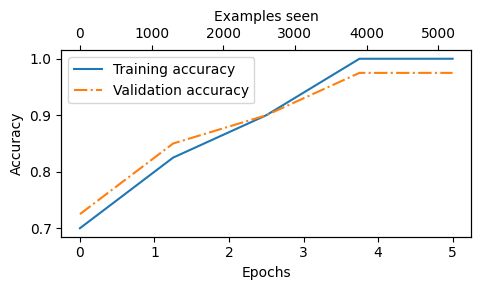

In [71]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

→ 에폭 4~5 이후 학습 및 검증 정확도가 비교적 높은 수준에 도달함을 확인


🧩 에폭(Epoch) 수 선택 가이드

- **기본 설정:**  
  훈련 시작 시 에폭 수를 **5**로 설정 (일반적으로 좋은 출발점)

- **에폭 수 결정 요인:**  
  - 데이터셋의 크기와 다양성  
  - 작업(task)의 난이도  
  - 과적합(overfitting) 발생 여부  

- **조정 기준:**  
  - ⚠️ **과적합 발생 시:** 에폭 수 **감소**  
  - 📉 **검증 손실 감소 추세가 계속될 때:** 에폭 수 **증가**

- **현재 실험 결과:**  
  - 과적합 징후 없음  
  - 검증 손실(validation loss)이 거의 0에 근접  
  → ✅ **5 에폭이 적절한 선택**

📘 *요약:*  
> 에폭 수는 고정된 정답이 없으며,  
> 손실 곡선(loss plot)을 관찰하며 **동적으로 조정**하는 것이 최선이다.

정확한 성능 평가(performance metrics) 를 위해,
이번에는 eval_iter 값을 정의하지 않고,
훈련(training), 검증(validation), 테스트(test) 세트 전체에 대해
성능 지표를 계산

In [65]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


🧩 훈련·검증·테스트 세트 성능 비교 요약

- **관찰 결과:**  
  - 훈련 세트와 테스트 세트의 성능이 **거의 동일**함.  
  - 정확도의 **약간의 차이**는 **경미한 과적합(minimal overfitting)** 을 의미.

- **일반적인 현상:**  
  - **검증 세트(Validation)** 정확도 > **테스트 세트(Test)** 정확도  
  - 이유: 모델 개발 중 **하이퍼파라미터 튜닝(hyperparameter tuning)** 이  
    검증 세트 성능을 기준으로 이루어지기 때문.

- **개선 방안:**  
  - **Dropout 비율(`drop_rate`)** 증가  
  - **Optimizer의 가중치 감쇠(`weight_decay`)** 조정  
  → 두 방법 모두 **과적합 완화 및 일반화 성능 향상**에 도움.

📘 *요약:*  
> 훈련·테스트 간 성능 차이는 정상적인 수준이며,  
> 미세한 과적합은 **정규화(regularization)** 설정 조정을 통해 줄일 수 있다.

---

### 6.8 Using the LLM as a spam classifier

🧩 스팸 메시지 분류 단계 요약

- **단계 개요:**  
  - 모델을 **미세 조정(fine-tune)** 및 **평가(evaluate)** 완료 후  
    → 스팸 메시지 분류 수행 (그림 6.18 참고)

- **사용 모델:**  
  - **GPT 기반 스팸 분류 모델 (GPT-based spam classification model)**

- **`classify_review` 함수 동작:**  
  1. **데이터 전처리(data preprocessing):**  
     - 이전에 구현한 `SpamDataset` 과 동일한 처리 방식 사용  
  2. **텍스트 → 토큰 ID 변환(tokenization)**  
  3. **모델 예측:**  
     - 모델이 **정수형 클래스 레이블(integer class label)** 출력  
     - (섹션 6.6의 예측 방식과 동일)  
  4. **출력:**  
     - 예측된 **클래스 이름(class name)** 반환

📘 *요약:*  
> `classify_review` 함수는 입력 텍스트를 전처리 → 토큰화 → 예측 → 클래스명 반환의 순서로 처리하며,  
> fine-tuned GPT 모델을 활용해 스팸 여부를 분류한다.

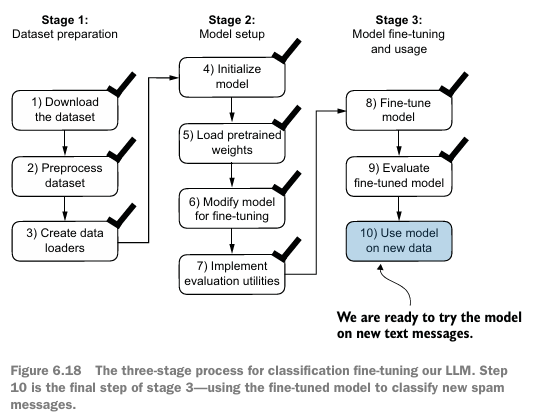

In [66]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # 모델 입력 준비
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # 참고: 책에서는 실수로 pos_emb.weight.shape[1]로 표기되어 있었습니다
    # 코드가 깨지지는 않지만 불필요하게 길이가 잘려서 1024 대신 768을 사용하게 됩니다

    # 시퀀스가 너무 길면 잘라냅니다
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )    
    # 더 견고한 버전은 아래와 같으며, max_length=None인 경우를 더 잘 처리합니다
    # max_len = min(max_length,supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]
    
    # 가장 긴 시퀀스 길이에 맞춰 패딩
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # 배치 차원 추가

    # 모델 추론
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 마지막 출력 토큰의 로짓
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 분류 결과 반환
    return "spam" if predicted_label == 1 else "not spam"

In [67]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [68]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


모델을 저장

In [69]:
torch.save(model.state_dict(), "review_classifier.pth")

모델 불러오기

In [70]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

---

🧩 요약 (Summary)

- **LLM 미세 조정(fine-tuning) 전략 종류:**  
  - **분류 기반 미세 조정(Classification fine-tuning)**  
  - **명령어 기반 미세 조정(Instruction fine-tuning)**  

---

- **분류 미세 조정(Classification fine-tuning):**  
  - LLM의 **출력층(output layer)** 을  
    **작은 분류층(classification layer)** 으로 교체하여 수행.  

---

- **스팸 분류 예시:**  
  - “spam” vs “not spam” → **2개의 출력 노드** 사용.  
  - 기존에는 어휘 수(vocabulary size, **50,256**) 만큼의 출력 노드를 사용했음.  

---

- **차이점 (Pretraining vs Fine-tuning):**  
  - Pretraining: **다음 토큰(next token)** 예측.  
  - Fine-tuning: **정확한 클래스 레이블(class label)** 예측  
    → 예: “spam”, “not spam”  

---

- **입력 형식:**  
  - 미세 조정 시 입력도 **텍스트를 토큰 ID(token IDs)** 로 변환한 형태로 사용하며,  
    이는 pretraining 과정과 동일함.  

---

- **미세 조정 전 단계:**  
  - 사전 학습된 LLM을 **기본(base) 모델** 로 로드한 후, 그 위에서 fine-tuning 수행.  

---

- **모델 평가(Evaluation):**  
  - **분류 정확도(Classification accuracy)** = 전체 예측 중 **정답의 비율(%)**  
  - 즉, 모델이 얼마나 정확히 “spam / not spam”을 구분했는지를 측정.  

---

- **손실 함수(Loss Function):**  
  - **크로스 엔트로피 손실(Cross Entropy Loss)** 사용.  
  - 이는 LLM의 **사전 학습(pretraining)** 단계에서 사용한 손실 함수와 동일함. 